In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from CHAMP.DataLoader import LoadData
from CHAMP.Monitor import DisplayDico, DisplayConvergenceClassif
from CHAMP.CHAMP_Layer import ConvMP
from CHAMP.DataTools import GenerateGabor, Rebuilt, ChangeBatchSize
from CHAMP.LowLevel import conv
from CHAMP.Classif_Layer import Classif_Layer
import matplotlib.pyplot as plt
import os
home = os.getenv('HOME')
from CHAMP.DataTools import SaveNetwork, LoadNetwork

In [2]:
l0 = 20
nb_dico = 8
dico_size = (5,5)
image_size = (28,28)
OutputL1_size =tuple(image_size[i]-dico_size[i]+1 for i in range(len(dico_size)))
saving_path = 'Records/'
lr=0.1
batch_size=2000
nb_epochs = 2000

# On MNIST DataBase

### Load the DataBase

In [3]:
path = "../../../Science/These/Rapport d'avancement/database/MNISTtorch/"
#path = home + "/science/VB_These/Rapport d'avancement/database/Face_DataBase/"
training_set,testing_set = LoadData('MNIST',data_path=path,avg_size=(5,5),GPU=False)

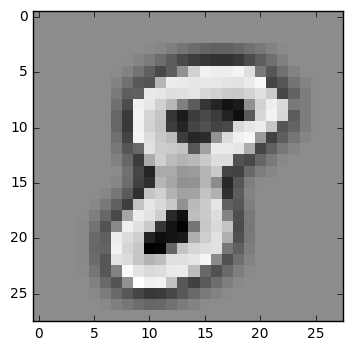

In [4]:
plot = plt.imshow(training_set[0][0,0,0,:,:].numpy(),cmap='gray')

## Classifying Raw data

In [5]:
SaveExp = True

In [6]:
batch_training_set = ChangeBatchSize(training_set,batch_size=batch_size)

In [7]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_Raw = Classif_Layer(nb_dico=1,size_image=image_size,nb_categories=10, verbose=0,GPU=False)
    Classifier_Raw.TrainClassifier(batch_training_set, nb_epoch=nb_epochs, data_test_loader=testing_set, lr=lr)
    SaveNetwork(Classifier_Raw, saving_path+'MNIST_ClassifRaw.pkl')
else : 
    Classifier_Raw = LoadNetwork(saving_path+'MNIST_ClassifRaw.pkl')

file saved


best accuracy : 91.65%


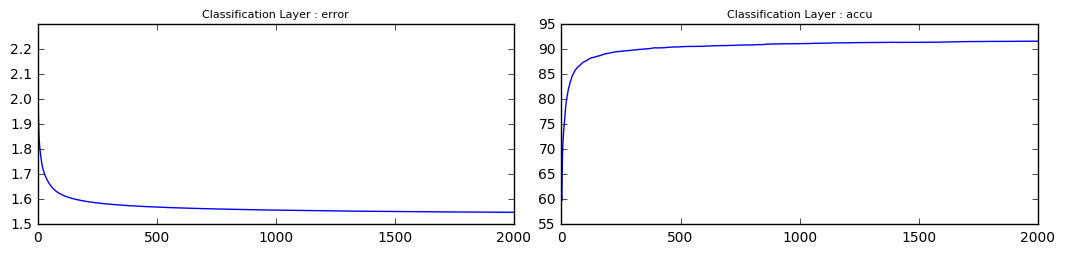

In [8]:
print('best accuracy : {0}%'.format(Classifier_Raw.accuracy_list[-1]))
DisplayConvergenceClassif(Classifier_Raw, to_display=['error','accu'])

### Generate Filters

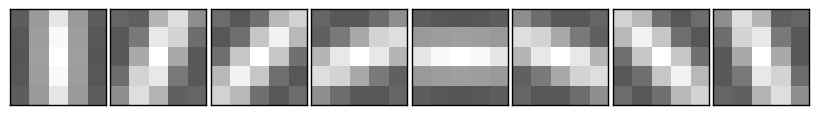

In [9]:
DicoGabor = GenerateGabor(nb_dico=nb_dico,dico_size=dico_size,sigma=1.5,lambd=5,gamma=0.5,psi=0,GPU=False)
DisplayDico(DicoGabor)

## Classifying Data After convolution

In [10]:
SaveExp = False

In [11]:
Output_L1Conv_training = conv(training_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_training = (Output_L1Conv_training.unsqueeze(0),training_set[1])
Output_L1Conv_testing = conv(testing_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_testing = (Output_L1Conv_testing.unsqueeze(0),testing_set[1])
Output_L1Conv_training  = ChangeBatchSize(Output_L1Conv_training,batch_size)

In [12]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CONV = Classif_Layer(nb_dico=nb_dico,size_image=OutputL1_size,verbose=0,nb_categories=10,GPU=False)
    Classifier_CONV.TrainClassifier(Output_L1Conv_training,nb_epoch=nb_epochs,\
                                                data_test_loader=Output_L1Conv_testing,lr=lr)
    SaveNetwork(Classifier_CONV, saving_path+'MNIST_ClassifConv.pkl')
else : 
    Classifier_CONV = LoadNetwork(saving_path+'MNIST_ClassifConv.pkl')

best accuracy : 92.53%


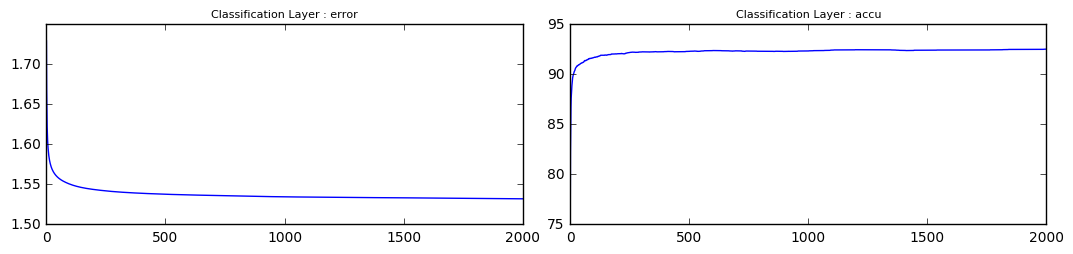

In [13]:
print('best accuracy : {0}%'.format(Classifier_CONV.accuracy_list[-1]))
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])

## Classifying Data After a sparse convolution

### Coding and reconstruction

In [14]:
code_training = ConvMP(image_input=training_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=5,
                modulation=None, verbose=0, train=True, doSym=None, mask=None,\
                MaskMod='Residual')

code_testing = ConvMP(image_input=testing_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=5,
                modulation=None, verbose=0, train=True, doSym=None, mask=None,\
                MaskMod='Residual')


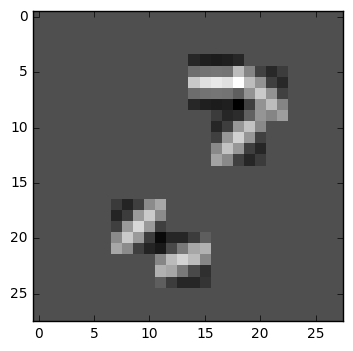

In [15]:
reconstructed_image = Rebuilt(code_training,DicoGabor)
plt.imshow(reconstructed_image[0,0,:,:].numpy(),cmap='gray')

### Classification

In [16]:
output_Layer1_training = (code_training.unsqueeze(0),training_set[1])
output_Layer1_testing = (code_testing.unsqueeze(0),testing_set[1])

In [ ]:
SaveExp = True
training_L1_CHAMP = ChangeBatchSize(output_Layer1_training,batch_size)

In [ ]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CHAMP = Classif_Layer(nb_dico=nb_dico,size_image=OutputL1_size,nb_categories=10,verbose=0,GPU=False)
    Classifier_CHAMP.TrainClassifier(training_L1_CHAMP,nb_epoch=nb_epochs,\
                                   data_test_loader=output_Layer1_testing ,lr=lr)
    SaveNetwork(Classifier_CHAMP, saving_path+'MNIST_ClassifRaw.pkl')
else : 
    Classifier_CHAMP = LoadNetwork(saving_path+'MNIST_ClassifRaw.pkl')

In [ ]:
print('best accuracy : {0}%'.format(Classifier_CHAMP.accuracy_list[-1]))
DisplayConvergenceClassif(Classifier_CHAMP, to_display=['error','accu'])

## Is Sparse Convolution Good

All the experiment, are located on Rapport D'avancement/2018-02-01/2018-02-01.ExpGPU_MNIST

Performance as a function of the sparsity

In [ ]:
sparsity = [2,5,10,20,50,60,70,80,90,100,150,200]
performance = [67.46,87.24,92.47,94.08,94.7,94.73,94.76,94.79,94.82,94.82,94.81,94.82] 

In [ ]:
plt.plot(sparsity,performance)

Sparse Convolution is better than classical convolution when sparsity >= 10